Welcome to My kernal 
# Problem statement: 
 All support teams are majorly depend upon Request center/Incident to track issues and health of their server, disk, and technology related issue. Here I come up with idea to track most occured issues as per incident count and then find what is the major contributer casue for this issue. So we can easlt track and resolve issue before we are flooded with same kind of issues.
 

1. collect dump
2. get all summary data
3. tokenize the summary into words
4. count the repeated issues
5. define stopkeywords
6. get the top 10 keywords


In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
incident_dump = pd.read_csv('Updated_report.csv',encoding='cp1252')

In [17]:
# Data cleaning and formating

incident_dump['Closed Date'] = pd.to_datetime(incident_dump['Closed Date'])
incident_dump['Submit Date'] = pd.to_datetime(incident_dump['Submit Date'])


incident_dump['Resolution'].fillna(method = 'ffill',inplace=True)
incident_dump.drop(['Assignee+'],axis=1,inplace=True)
incident_dump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
Incident ID*+    1000 non-null object
Closed Date      1000 non-null datetime64[ns]
Summary*         1000 non-null object
Resolution       1000 non-null object
Submit Date      1000 non-null datetime64[ns]
Notes            999 non-null object
dtypes: datetime64[ns](2), object(4)
memory usage: 47.0+ KB


In [34]:
# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorize = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorize.build_analyzer()

def wordcounts(summary):
    word_tocken = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(summary):
        key_value_pair = {}
        # find counts of the vocabularies and transform to array 
        words_array = vectorize.fit_transform([summary]).toarray()
        # vocabulary and index (index of w)
        vc = vectorize.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            key_value_pair[v]=k # key_value_pair -> index:word 
        for index,value in enumerate(words_array[0]):
            word_tocken[key_value_pair[index]] = value # c -> word:count
    return  word_tocken
        

    
#collecting tockenize of Summary Data
incident_dump['words'] = incident_dump['Summary*'].apply(wordcounts)   


# list of most occuring Issues
count_word = {}

for d in incident_dump['words']:
    for k,v in d.items():
        if(k not in count_word):
            count_word[k] = v
        else:
            count_word[k] = count_word[k] + v
            
            
# droping stop words
stop_word = ['{C}','-','issue','(1480)','2016','DB','is','failed.','Issue:']
sw = pd.read_csv('stop_words.csv')
sw.drop('Unnamed: 1',axis=1,inplace=True)
sw.append(stop_word)
for i in sw:
    if(i in count_word):
        del count_word[i]
        
for i in stop_word:
    if(i in count_word):
        del count_word[i]
            
            
list_of_issues = sorted(count_word.items(), key=lambda x: x[1], reverse=True)
list_of_issues[0:10]


[('cloud', 734),
 ('hosts', 734),
 ('cluster', 522),
 ('failed', 393),
 ('server', 348),
 ('mssqlserver', 303),
 ('service', 287),
 ('resource', 250),
 ('sql', 203),
 ('microsoft', 203)]

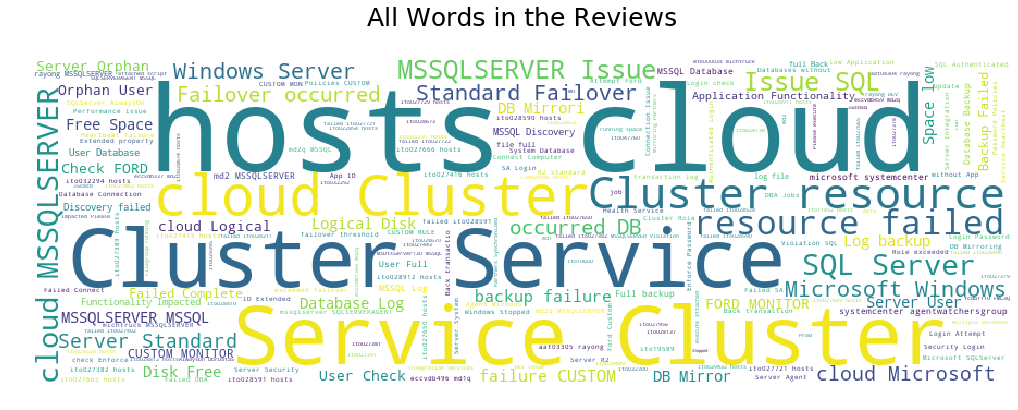

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

rt = incident_dump['Summary*']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))

plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

In [20]:

#Selected Incident types
selectedwords = ['cluster','failover','backup','mirror','disk','orphan','backup','discovery','mirroring','login','password'
                ,'heartbeat','performance']
#dfwc = data.copy()


def selectedcount(dic,word):
    '''
    Count of each word occured in summary
    '''
    if word in dic:
        return dic[word]
    else:
        return 0

    
for word in selectedwords:
    incident_dump[word] = incident_dump['words'].apply(selectedcount,args=(word,))


# Month wise issue frequency    
incident_dump['month'] = pd.DatetimeIndex(incident_dump['Submit Date']).month



monthly_occurance = incident_dump.groupby(['month']).sum()

Result = []

#Threshold value set to 30

previous_value = 30 

for next_value in monthly_occurance.sum(axis=1):
    if( (next_value > previous_value)  & ((next_value - previous_value)>10)):
        Result.append(1)
    else: Result.append(0)
    previous_value = next_value
monthly_occurance['Result'] = Result  

monthly_occurance.drop('Result',axis=1).sum(axis=1)
monthly_occurance.describe().T





,count,mean,std,min,25%,50%,75%,max
cluster,12.0,43.500000,77.460254,0.0,2.00,7.0,43.50,248.0
failover,12.0,13.750000,25.241110,0.0,0.00,2.0,11.25,68.0
backup,12.0,12.416667,16.345466,0.0,2.00,5.0,16.00,52.0
mirror,12.0,5.916667,12.332207,0.0,0.00,0.5,2.00,36.0
disk,12.0,6.666667,8.563488,0.0,0.75,4.0,7.25,24.0
orphan,12.0,5.083333,7.012435,0.0,1.00,2.5,6.75,25.0
discovery,12.0,3.750000,5.119038,0.0,0.00,1.5,5.00,14.0
mirroring,12.0,1.583333,3.175426,0.0,0.00,0.0,1.50,11.0
login,12.0,3.000000,4.512609,0.0,0.00,1.0,3.25,14.0
password,12.0,1.750000,3.137022,0.0,0.00,1.0,1.25,11.0


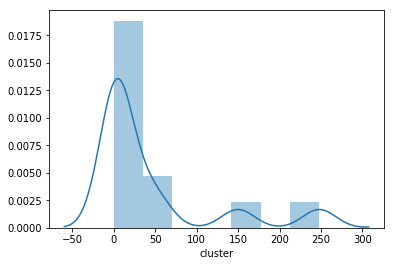

In [21]:
#visualization

import seaborn as sns
sns.distplot(monthly_occurance['cluster'])

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,confusion_matrix



test_x = monthly_occurance.drop('Result',axis=1)
test_y = monthly_occurance['Result']
X_train, X_test, y_train, y_test = train_test_split(test_x, test_y, test_size=0.2, random_state=42)

# create object of Logistic Regression
model = LogisticRegression()
start=dt.datetime.now()
#Fit data model
model.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
#Predict Data
predict =model.predict(X_test)
print('Model Score: ',model.score(X_test,y_test))

print('Confusion Matrix: \n', confusion_matrix(y_test.values,predict))


print(classification_report(y_test.values,predict,target_names=['Green','Red']))




Elapsed time:  0:00:00.000997
Model Score:  0.6666666666666666
Confusion Matrix: 
 [[2 1]
 [0 0]]
              precision    recall  f1-score   support

       Green       1.00      0.67      0.80         3
         Red       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3



C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [49]:
from sklearn.naive_bayes import MultinomialNB

start=dt.datetime.now()
model1 = MultinomialNB()
model1.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

print('Model Score: ',model1.score(X_test,y_test))

print('Confusion Matrix: \n', confusion_matrix(y_test.values,predict))


print(classification_report(y_test.values,predict,target_names=['Green','Red']))

Elapsed time:  0:00:00.171960
Model Score:  0.6666666666666666
Confusion Matrix: 
 [[2 1]
 [0 0]]
              precision    recall  f1-score   support

       Green       1.00      0.67      0.80         3
         Red       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3



C:\Users\chand\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
